# WARS: Wes Anderson Recommendation System

By Jacob Klein and Omar Pardo Gomez (Columbia University)

## Business Problem

We are _Best Film Recommenders (BFR)_, a company located in NYC and founded by two Columbia Students in 2014. Since our inception, we have been recognized by our users for our accurate and personalized movie recommendations. However, our industry is always evolving, requiring constant improvements to remain competitive and profitable.

A week ago we received a letter from _Wes Anderson Productions (WAP)_, the company which owns the rights for every movie directed by Wes Anderson. Within the letter they claim that despite the high quality of Wes Anderson's films, most of his work is still unknown by most consumers. The only exceptions are _The Grand Budapest Hotel (2014)_ (which received critical acclaim, including nine Oscars nominations), and _Isle of Dogs (2018)_, which popularity was boosted by the former's success.

Due to WAP films having high ratings yet low viewership, the company believes that six of Wes Anderson's films are unpopular due to a lack of publicity when they were released. With the Christmas season approaching, WAP believe that target advertising can bring in new viewers that never knew the movies existed, increasing revenue from movie sales. For this reason, WAP are willing to pay a significant sum of money if we can reach more users, representing a significant potential income for our company.

While we could recommend the six movies to all our customers, our company's mission has always been focussed on our users, and we don't want to make recommendations they can find irrelevant. Because of this, we would like to find the movie which is most likely to be enjoyed by each user among the following films: 

* _Rushmore (1998)_
* _The Royal Tenenbaums (2001)_
* _The Life Aquatic with Steve Zissou (2004)_
* _The Darjeeling Limited (2007)_
* _Fantastic Mr. Fox (2009)_
* _Moonrise Kingdom (2012)_

Therefore, our goal will be to build a new _Wes Anderson Recommendation System (WARS)_, to find the ideal movie per user. While we have no _accuracy cutoff_, we want our recommendations to be as targeted as possible to keep a high availability of advertising space, should new clients wish to use our services.

## Data Overview

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import collections

Similar to our previous recommendation systems, we are going to use subsets of the full data set for education and development from [MovieLens](https://grouplens.org/datasets/movielens/). For now let's focus on the main table: The `ratings` table contains the **rating** that a **user** gave to one **movie**, as well as the moment in **time** when this happened.

df_ratings = pd.read_csv('movie_data/ratings.csv')
df_ratings.head(5)

From previous experience we know that people can change their preferences and opinions over time. Therefore, to ensure the quality of our data, we will use only ratings given since 2016.

In [5]:
def get_year(ts):
    return datetime.fromtimestamp(int(ts)).year

df_ratings['year'] = df_ratings['timestamp'].apply(get_year)
min_year = 2016
df_ratings = df_ratings[df_ratings.year >= min_year][['userId', 'movieId', 'rating']]

Before we start, let's confirm or deny the _WAP_'s hypothesis: Are the six proposed movies truly unpopular, but good?

To do that, let's count the number of total opinions, and the average rating of all the movies in the dataset, and then compare them with the _WAP_ movies.

In [7]:
df_movies = df_ratings.groupby(['movieId']).agg({'rating':['count', np.mean]}).rating
wap_movies = np.array([2395, 4979, 30810, 55269, 72226, 94959])

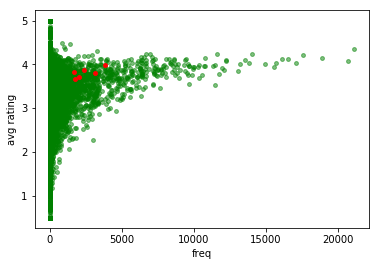

In [8]:
x = df_movies['count']
y = df_movies['mean']
x_wap = df_movies[df_movies.index.isin(wap_movies)]['count']
y_wap = df_movies[df_movies.index.isin(wap_movies)]['mean']

plt.scatter(x, y, c="green", alpha=0.5, s=15)
plt.scatter(x_wap, y_wap, c="red", s=15)
plt.xlabel("freq")
plt.ylabel("avg rating")
plt.show()

Watching the red points (_WAP_ movies), they are up to the left. In other words, the six proposed movies seem to be unpopular, but good, confirming the hypothesis.

## Previous Approaches

Since we had never faced a similar problem before, and to maximize the breadth of our training, we designed datasets with different characteristics, tried multiple kinds of recommendation techniques, and fitted the models by shifting several hyperparameters. All with the intention to find what worked and what didn't for the beta version of _WARS_.

### Datasets

Our first idea for the model dataset was to use as items **only the six WAP proposed movies**. However, we thought that working with only six items could be insufficient for a recommendation system. Then, we decided to add other **unpopular-but-good** movies, which we called **target movies**. To be more specific, we defined a target movie as one with between **1500 and 4000 opinions** since 2016, and an **average rating greater or equal than 3.6**. This kind of movies are shown as a rectangle in the next plot.

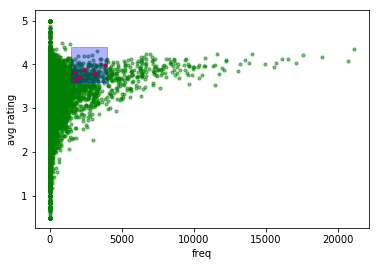

In [10]:
from matplotlib.patches import Rectangle
plt.scatter(x, y, c="green", alpha=0.5, s=10)
plt.scatter(x_wap, y_wap, c="red", s=10)
ax = plt.gca()
ax.add_patch(Rectangle((1500, 3.6), 2500, 0.8, color='b', alpha=0.3))
plt.xlabel("freq")
plt.ylabel("avg rating")
plt.show()

Finally, we built a third dataset that included films **at least as popular** as the previous ones (more than 1500 opinions since 2016), but which were **not considered target**, either because they had more than 4000 opinions, or because their average rating was lower than 3.6.

### Recommendation Techniques

All the recommendation techiniques we used for the previous approach belonged to the **collaborative filtering** methods. That means they all use nothing but the ratings the different users gave to the movies in the *MovieLens* catalog. We tried with **neighborhood-based techniques** (focusing on **items**, because that is the nature of this problem), particularly several kinds of *k-NN* methods (basic, with means, with z-score). Also, we used **model-based** techniques, particularly matrix factorization methods as SVD and SVD++. To fit all these recommendation algorithms we tried different hyperparameters thanks to the Python `suprise` library, which turned out to be very useful for that initial approach.

### Insights

The two main insights we got from that previous approach were the following:

- After training models with the three previously described datasets, even when we calculated the accuracy metrics just for the WAP movies, the **best performance** was obtained when we included **all the movies** (wap movies, target movies and non-target movies). Our hypothesis is that the more data you give it, the better the algorithm behaves. That is in general, and in particular, for the Wes Anderson films' ratings predictions.

- The SVD++ got the **best accuracy** among the collaborative filtering techniques. That suggests that the **matrix factorization techniques** can work well for this problem.

## New Approach: Factorization Machines

**Factorization Machines (FMs)** are a novel technique, and a **state of the art solution** within the Recommendation Systems context. This technique allows the algorithm to **add information different from the *user-movie* ratings** and is similar to the matrix factorization techniques in the sense that also **works with latent vectors** to generate interactions. Therefore, seems like the **ideal algorithm** to explore even more what we already learned using the collaborative filtering approach.

### Features

In [ ]:
df_movies = pd.read_csv('movie_data/movies.csv')
df_tags = pd.read_csv('movie_data/tags.csv')
df_genome_scores = pd.read_csv('movie_data/genome-scores.csv')
df_genome_tags = pd.read_csv('movie_data/genome-tags.csv')
df_genome = pd.merge(df_genome_scores, df_genome_tags, on='tagId', how='inner')